# Transformer model - Machine Translation

### Tutorial Topics
- Transformer model

### Software Requirements
- Python (>=3.6)
- PyTorch (>=1.2.0) 
- Jupyter (latest)
- torchtext
- NLTK

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Import libraries, dataset and prepare necessary functions

In [0]:
import unicodedata
import string
import re
import random
import time
import datetime
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
import torchtext
from torchtext.datasets import TranslationDataset

import spacy
import numpy as np

import math, copy, time
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

In [0]:
def inference(model, file_name, src_vocab, trg_vocab, attention= True, max_trg_len = 64):
    '''
    Function for translation inference

    Input: 
    model: translation model;
    file_name: the directoy of test file that the first column is target reference, and the second column is source language;
    trg_vocab: Target torchtext Field
    attention: the model returns attention weights or not.
    max_trg_len: the maximal length of translation text (optinal), default = 64

    Output:
    Corpus BLEU score.
    '''
    from nltk.translate.bleu_score import corpus_bleu
    from nltk.translate.bleu_score import sentence_bleu
    from torchtext.data import TabularDataset
    from torchtext.data import Iterator

    # convert index to text string
    def convert_itos(convert_vocab, token_ids):
        list_string = []
        for i in token_ids:
            if i == convert_vocab.vocab.stoi['<eos>']:
                break
            else:
                token = convert_vocab.vocab.itos[i]
                list_string.append(token)
        return list_string

    test = TabularDataset(
      path=file_name, # the root directory where the data lies
      format='tsv',
      skip_header=True, # if your tsv file has a header, make sure to pass this to ensure it doesn't get proceesed as data!
      fields=[('TRG', trg_vocab), ('SRC', src_vocab)])

    test_iter = Iterator(
    dataset = test, # we pass in the datasets we want the iterator to draw data from
    sort = False,batch_size=128,
    sort_key=None,
    shuffle=False,
    sort_within_batch=False,
    device = device,
    train=False
    )
  
    model.eval()
    all_trg = []
    all_translated_trg = []

    TRG_PAD_IDX = trg_vocab.vocab.stoi[trg_vocab.pad_token]

    with torch.no_grad():
    
        for i, batch in enumerate(test_iter):

            src = batch.SRC
            #src = [src len, batch size]

            trg = batch.TRG
            #trg = [trg len, batch size]

            batch_size = trg.shape[1]

            # create a placeholder for traget language with shape of [max_trg_len, batch_size] where all the elements are the index of <pad>. Then send to device
            trg_placeholder = torch.Tensor(max_trg_len, batch_size)
            trg_placeholder.fill_(TRG_PAD_IDX)
            trg_placeholder = trg_placeholder.long().to(device)
            if attention == True:
              output,_ = model(src, trg_placeholder, 0) #turn off teacher forcing
            else:
              output = model(src, trg_placeholder) #turn off teacher forcing
            # get translation results, we ignor first token <sos> in both translation and target sentences. 
            # output_translate = [(trg len - 1), batch, output dim] output dim is size of target vocabulary.
            output_translate = output[1:]
            # store gold target sentences to a list 
            all_trg.append(trg[1:].cpu())

            # Choose top 1 word from decoder's output, we get the probability and index of the word
            prob, token_id = output_translate.data.topk(1)
            translation_token_id = token_id.squeeze(2).cpu()

            # store gold target sentences to a list 
            all_translated_trg.append(translation_token_id)
      
    all_gold_text = []
    all_translated_text = []
    for i in range(len(all_trg)): 
        cur_gold = all_trg[i]
        cur_translation = all_translated_trg[i]
        for j in range(cur_gold.shape[1]):
            gold_convered_strings = convert_itos(trg_vocab,cur_gold[:,j])
            trans_convered_strings = convert_itos(trg_vocab,cur_translation[:,j])

            all_gold_text.append(gold_convered_strings)
            all_translated_text.append(trans_convered_strings)

    corpus_all_gold_text = [[item] for item in all_gold_text]
    corpus_bleu_score = corpus_bleu(corpus_all_gold_text, all_translated_text)  
    return corpus_bleu_score

In [0]:
manual_seed = 77
torch.manual_seed(manual_seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
n_gpu = torch.cuda.device_count()
if n_gpu > 0:
    torch.cuda.manual_seed(manual_seed)

cuda


In [0]:
!python -m spacy download en_core_web_sm
!python -m spacy download fr_core_news_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
     |████████████████████████████████| 13.1MB 595kB/s 
  Created wheel for fr-core-news-sm: filename=fr_core_news_sm-2.1.0-cp36-none-any.whl size=13156209 sha256=10187dadd39fc3596f9be2fd4756a7ec351f971744a576079d12e2ce928a39b8
  Stored in directory: /tmp/pip-ephem-wheel-cache-unsvnxw7/wheels/ab/82/2a/61dd0ff02e22f10eef65a5aa35453a0eb745c84b4c874b612f
Successfully built fr-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')


In [0]:
import fr_core_news_sm
import en_core_web_sm

spacy_fr = fr_core_news_sm.load()
spacy_en = en_core_web_sm.load()

In [0]:
def tokenize_fr(text):
    """
    Tokenizes French text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_fr.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [0]:
SRC = torchtext.data.Field(tokenize = tokenize_fr, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)
TRG = torchtext.data.Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

In [0]:
train, val, test = torchtext.data.TabularDataset.splits(
    path='./drive/My Drive/Colab Notebooks/eng-fre/', train='train_eng_fre.tsv',validation='val_eng_fre.tsv', test='test_eng_fre.tsv', 
    format='tsv', skip_header=True, fields=[('TRG', TRG), ('SRC', SRC)])

In [0]:
print(f"Number of training examples: {len(train.examples)}")
print(f"Number of validation examples: {len(val.examples)}")
print(f"Number of testing examples: {len(test.examples)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


In [0]:
TRG.build_vocab(train,min_freq=2)
SRC.build_vocab(train,min_freq=2)

In [0]:
print(f"Unique tokens in source (fr) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (fr) vocabulary: 6473
Unique tokens in target (en) vocabulary: 5893


In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [0]:
train_iter, val_iter, test_iter = torchtext.data.BucketIterator.splits(
    (train, val, test), # we pass in the datasets we want the iterator to draw data from
    batch_sizes=(16, 256, 256),device = device,
    sort_key=lambda x: len(x.SRC), # the BucketIterator needs to be told what function it should use to group the data.
    sort_within_batch=False)

In [0]:
# batch example of training data
for batch in train_iter:
    src = batch.SRC
    trg = batch.TRG
    print('tensor size of source language:', src.shape)
    print('tensor size of target language:', trg.shape)
    print('the tensor of first example in target language:', trg[:,0])
    break

tensor size of source language: torch.Size([29, 16])
tensor size of target language: torch.Size([27, 16])
the tensor of first example in target language: tensor([  2,   4,  38,  12, 362, 753,  57,   4, 101,  77,   5,   3,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1],
       device='cuda:0')


# Transformer



![](https://nlp.seas.harvard.edu/images/the-annotated-transformer_14_0.png)


Picture Courtesy: https://nlp.seas.harvard.edu/images/the-annotated-transformer_14_0.png


## Positional Encoding

**Positional encodings** added to the input embeddings at the bottoms of encoder and decoder stackes. 

**Positional encodings** have the samle dimension $d_{model}$ of as the embeddings, so two can be summed: 

$$PE(pos,2_i) = sin(pos/10000^{2i/d_{model}} )$$
$$PE(pos,2_i+1) = cos(pos/10000^{2i/d_{model}} )$$

where $pos$ is the position and $i$ is the dimension.


### Example for positional encodings

In [0]:
max_seq_len = 10
d_model = 10

pe = torch.zeros(max_seq_len, d_model)

for pos in range(max_seq_len):
  for i in range(0,d_model,2):
    pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
    pe[pos, i+1] = math.cos(pos / (10000 ** ((2 * i+1)/d_model)))

print(pe)

tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  9.2180e-01,  2.5116e-02,  9.9995e-01,  6.3096e-04,
          1.0000e+00,  1.5849e-05,  1.0000e+00,  3.9811e-07,  1.0000e+00],
        [ 9.0930e-01,  6.9942e-01,  5.0217e-02,  9.9980e-01,  1.2619e-03,
          1.0000e+00,  3.1698e-05,  1.0000e+00,  7.9621e-07,  1.0000e+00],
        [ 1.4112e-01,  3.6764e-01,  7.5285e-02,  9.9955e-01,  1.8929e-03,
          1.0000e+00,  4.7547e-05,  1.0000e+00,  1.1943e-06,  1.0000e+00],
        [-7.5680e-01, -2.1631e-02,  1.0031e-01,  9.9920e-01,  2.5238e-03,
          1.0000e+00,  6.3396e-05,  1.0000e+00,  1.5924e-06,  1.0000e+00],
        [-9.5892e-01, -4.0752e-01,  1.2526e-01,  9.9875e-01,  3.1548e-03,
          1.0000e+00,  7.9245e-05,  1.0000e+00,  1.9905e-06,  1.0000e+00],
        [-2.7942e-01, -7.2968e-01,  1.5014e-01,  9.9820e-01,  3.7857e-03,
          1.0000e+00,  9.5094e-0

In [0]:
print("\n-- Positional encodeing for w in position 3: \n\n", pe[2,:])


-- Positional encodeing for w in position 3: 

 tensor([9.0930e-01, 6.9942e-01, 5.0217e-02, 9.9980e-01, 1.2619e-03, 1.0000e+00,
        3.1698e-05, 1.0000e+00, 7.9621e-07, 1.0000e+00])


We assume our embedding vector for w in position 3 is:

In [0]:
word_embedding = torch.rand((10))
print(word_embedding)

tensor([0.7740, 0.3854, 0.4050, 0.0702, 0.2818, 0.7120, 0.7528, 0.3129, 0.2615,
        0.5869])


We simply sum these two vector.

In [0]:
added = pe[2,:] + word_embedding
print("\n-- Embedding vector and positional encodeing added: \n\n", added)


-- Embedding vector and positional encodeing added: 

 tensor([1.6833, 1.0848, 0.4552, 1.0700, 0.2831, 1.7120, 0.7528, 1.3129, 0.2615,
        1.5869])



Furthermore, we apply dropout on top of the sums of embeddings and positional encodings. 

Build a function for positional encodings.

In [0]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

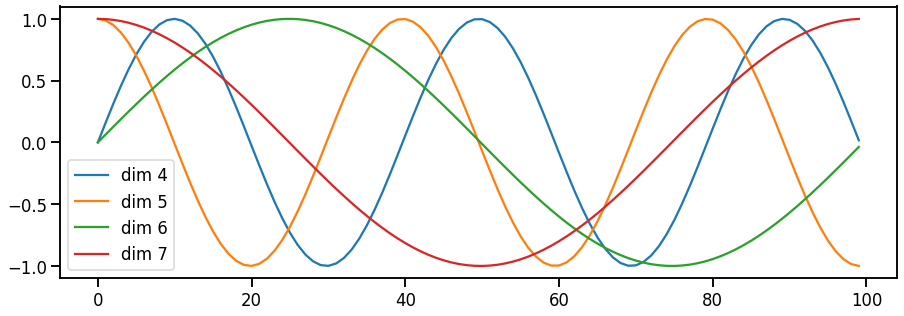

In [0]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

### Attention

An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.

Intuition: Retrieving from a database, we issue a query (q) to identify a key (k) that has a similaity. based on a value (v), to q.

In Transformer, we use “Scaled Dot-Product Attention”. The input includes queries and keys of dimension $d_k$, and values of dimension $d_v$. We compute the dot products of the query with all keys, divide each by $\sqrt{d_k}$, and apply a softmax function to obtain the weights on the values.


![](https://nlp.seas.harvard.edu/images/the-annotated-transformer_33_0.png)

Picture Courtesy: https://nlp.seas.harvard.edu/images/the-annotated-transformer_33_0.png


We introduced two attention alignment functions (i.e., additive attention and dot-product (multiplicative) attention) in previous labs. Dot-product attention is identical to Scaled Dot-Product Attention, except for the scaling factor of $\frac{1}{\sqrt{d_k}}$. 

In practice, we compute the attention function on a set of queries simultaneously, packed together into a matrix $Q$. The keys and values are also packed together into matrices $K$ and $V$. We compute the matrix of outputs as:

In [0]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn


![](https://nlp.seas.harvard.edu/images/the-annotated-transformer_38_0.png)

Picture Courtesy: https://nlp.seas.harvard.edu/images/the-annotated-transformer_38_0.png

Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this.
Where the projections are parameter matrices $W^Q_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^K_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^V_i \in \mathbb{R}^{d_{\text{model}} \times d_v}$ and $W^O \in \mathbb{R}^{hd_v \times d_{\text{model}}}$. In work of Vaswani et al., they employ $h=8$ parallel attention layers, or heads. For each of these they use $d_k=d_v=d_{\text{model}}/h=64$. 

In [0]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

## Pytorch inplementation

More details please check [here](https://pytorch.org/docs/master/_modules/torch/nn/modules/transformer.html#Transformer)

In [0]:
class Transformer(nn.Module):
  def __init__(self):
    super(Transformer, self).__init__(self, src_vocab, trg_vocab, embed_dim, nhead, num_encoder_layers, dropout, num_decoder_layers, dim_feedforward)
    # get initial hyper-parameters
    self.src_vocab = src_vocab
    self.trg_vocab = trg_vocab
    self.embed_dim = embed_dim
    self.nhead = nhead
    self.num_encoder_layers = num_encoder_layers
    self.dropout = dropout
    self.num_decoder_layers = num_decoder_layers
    self.dim_feedforward = dim_feedforward
    # add embedding layers
    self.embedding_encoder = nn.Embedding(self.src_vocab, self.embed_dim)
    self.embedding_decoder = nn.Embedding(self.trg_vocab , self.embed_dim)
    # Encoder-Decoder Transformer
    self.transformer = nn.Transformer(d_model= self.embed_dim,nhead=self.nhead, num_encoder_layers=self.num_encoder_layers, dropout=self.dropout, num_decoder_layers=self.num_decoder_layers, dim_feedforward=self.dim_feedforward)
    
    # output layer to predict next token
    self.decoder = nn.Linear(self.embed_dim, self.trg_vocab)

  def forward(self, src, tgr):
    # embedding layer
    src = self.embedding_encoder(src)
    tgr = self.embedding_decoder(tgr)

    # Transformer
    output = self.transformer(src, tgr)

    # predication 
    output = self.decoder(output) 
    return F.softmax(output, dim=1)

In [0]:
src_vocab = len(SRC.vocab)
trg_vocab = len(TRG.vocab)
embed_dim = 512
nhead = 4
num_encoder_layers = 1
dropout - 0.5 
num_decoder_layers = 1
dim_feedforward = 512

model = Transformer(src_vocab, trg_vocab, embed_dim, nhead, num_encoder_layers, dropout, num_decoder_layers, dim_feedforward).to(device)

NameError: ignored

In [0]:
# batch example of training data
for batch in train_iter:
    src = batch.SRC
    trg = batch.TRG
    model(src,trg)
    
    print('tensor size of source language:', src.shape)
    print('tensor size of target language:', trg.shape)
    print('the tensor of first example in target language:', trg[:,0])
    break

tensor size of source language: torch.Size([24, 16])
tensor size of target language: torch.Size([20, 16])
the tensor of first example in target language: tensor([ 2,  4, 59, 35, 10, 79,  8,  7, 96,  5,  3,  1,  1,  1,  1,  1,  1,  1,
         1,  1], device='cuda:0')


In [0]:
def train(model, iterator, optimizer, criterion):
    manual_seed = 77
    torch.manual_seed(manual_seed)
    if n_gpu > 0:
        torch.cuda.manual_seed(manual_seed)
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.SRC
        trg = batch.TRG
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        # loss function works only 2d logits, 1d targets
        # so flatten the trg, output tensors. Ignore the <sos> token
        # trg shape shape should be [(sequence_len - 1) * batch_size]
        # output shape should be [(sequence_len - 1) * batch_size, output_dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        
        optimizer.step()
        
        epoch_loss += loss.item()
    bleu = inference(model, "./drive/My Drive/Colab Notebooks/eng-fre/val_eng_fre.tsv", SRC, TRG, False, 64)
    return epoch_loss / len(iterator), bleu

In [0]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.SRC
            trg = batch.TRG

            output = model(src, trg) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    bleu = inference(model, "./drive/My Drive/Colab Notebooks/eng-fre/val_eng_fre.tsv", SRC, TRG, False, 64)
    return epoch_loss / len(iterator) , bleu

In [0]:
def init_weights(m):
    manual_seed = 77
    torch.manual_seed(manual_seed)
    if n_gpu > 0:
        torch.cuda.manual_seed(manual_seed)
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.05)
        else:
            nn.init.constant_(param.data, 0)

In [0]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [0]:
model.apply(init_weights)
optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [0]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
print('<pad> token index: ',TRG_PAD_IDX)
## we will ignor the pad token in true target set
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

<pad> token index:  1


In [0]:
N_EPOCHS = 15

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss,bleu_train = train(model, train_iter, optimizer, criterion)
    valid_loss, bleu = evaluate(model, val_iter, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # Create checkpoint at end of each epoch
    state_dict_model = model.state_dict() 
    state = {
        'epoch': epoch,
        'state_dict': state_dict_model,
        'optimizer': optimizer.state_dict()
        }

    # torch.save(state, "./drive/My Drive/Colab Notebooks/ckpt_ex1/seq2seq_"+str(epoch+1)+".pt")

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\t Train Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    print(f'\t Train BLEU:{bleu_train:.3f} |  Val. BLEU: {bleu:7.3f}')

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Epoch: 01 | Time: 0m 30s
	 Train Loss: 5.127 | Train PPL: 168.541
	 Val. Loss: 7.226 |  Val. PPL: 1374.088
	 Train BLEU:0.300 |  Val. BLEU:   0.300
Epoch: 02 | Time: 0m 30s
	 Train Loss: 4.914 | Train PPL: 136.146
	 Val. Loss: 5.135 |  Val. PPL: 169.814
	 Train BLEU:0.254 |  Val. BLEU:   0.254
Epoch: 03 | Time: 0m 29s
	 Train Loss: 4.819 | Train PPL: 123.881
	 Val. Loss: 4.787 |  Val. PPL: 119.993
	 Train BLEU:0.281 |  Val. BLEU:   0.281
Epoch: 04 | Time: 0m 29s
	 Train Loss: 4.863 | Train PPL: 129.379
	 Val. Loss: 4.706 |  Val. PPL: 110.600
	 Train BLEU:0.256 |  Val. BLEU:   0.256
Epoch: 05 | Time: 0m 30s
	 Train Loss: 4.876 | Train PPL: 131.099
	 Val. Loss: 5.356 |  Val. PPL: 211.953
	 Train BLEU:0.255 |  Val. BLEU:   0.255
Epoch: 06 | Time: 0m 28s
	 Train Loss: 4.915 | Train PPL: 136.369
	 Val. Loss: 4.858 |  Val. PPL: 128.756
	 Train BLEU:0.000 |  Val. BLEU:   0.000
Epoch: 07 | Time: 0m 28s
	 Train Loss: 4.886 | Train PPL: 132.423
	 Val. Loss: 6.182 |  Val. PPL: 483.749
	 Train BLE

# Reference:

https://nlp.seas.harvard.edu/2018/04/03/attention.html#position-wise-feed-forward-networks

https://pytorch.org/docs/master/nn.html#transformerencoderlayer

https://pytorch.org/docs/master/_modules/torch/nn/modules/transformer.html#Transformer